In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import joblib
import os
import scipy.io as sio
import cmocean as cm
import geopandas as gpd

In [2]:
xmin = -71.25+0.05
xmax = -69.75-0.05
ymin = 41.6+0.05
ymax = 42.8-0.05

In [3]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.pca import PCA_AE
from src.models.mlp import MLP_AE
from src.models.cnn import CNN_AE

from src.utils import *

In [4]:
project = 'fvcom'

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs(f'{project_root}/src/models/checkpoints/{project}', exist_ok=True)

load_existing_models = True
latent_dim = 20

In [59]:
states = gpd.read_file(f'{project_root}/data/massachusetts/s_08mr23.shp')
mass = states[states['NAME']=='Massachusetts']

In [17]:
grid_x = np.load(f'{project_root}/data/{project}/grid_x.npy')
grid_y = np.load(f'{project_root}/data/{project}/grid_y.npy')
grid_x_m, grid_y_m = sp_proj('forward', grid_x, grid_y,  'm')

u1 = np.load(f'{project_root}/data/{project}/u_interp.npy') 
u2 = np.load(f'{project_root}/data/{project}/v_interp.npy')
nt, n1, n2 = u1.shape
mask = ~np.isnan(u1[0,:,:])

X, scaler = transform_data_for_AE(u1,u2)
data = transform_data_for_AE_inverse(X, scaler)
data[:, :, ~mask] = np.nan 

In [18]:
# === Consistent train/val/test split ===
n_train = int(0.5 * nt)
n_val = int(0.2 * nt)
n_test = nt - n_train - n_val

train_idx = np.arange(0, n_train)
val_idx = np.arange(n_train, n_train + n_val)
test_idx = np.arange(n_train + n_val, nt)


X_train = X[train_idx]
X_val = X[val_idx]
X_test = X[test_idx]

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (7737, 2, 64, 64), Val shape: (3095, 2, 64, 64), Test shape: (4643, 2, 64, 64)


In [19]:
mlp_input_dim = X[:, :, mask].reshape(X.shape[0], -1).shape[1]

In [20]:
pca = PCA_AE.load(f'{project_root}/src/models/checkpoints/{project}/pca_{latent_dim}_model.pkl')
mlp = MLP_AE(input_dim=mlp_input_dim, latent_dim=latent_dim, mask=mask)
mlp.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_model.pth'))
mlp.to(device)
cnn = CNN_AE(latent_dim=latent_dim)
cnn.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_model.pth'))
cnn.to(device);

In [21]:
# Compute test error for each model
mask_broadcast = mask[None, :, :]  # shape (1, n1, n2)

# 1. PCA only (reconstruction from PCA)
X_pca_recon, Z_pca = pca.forward(X)
X_pca_recon = transform_data_for_AE_inverse(X_pca_recon, scaler)

# 2. MLP Autoencoder
mlp.eval()
with torch.no_grad():
    X_mlp_recon, Z_mlp = mlp(torch.tensor(X, dtype=torch.float32, device=device))
    X_mlp_recon = X_mlp_recon.cpu().numpy()
    X_mlp_recon = transform_data_for_AE_inverse(X_mlp_recon, scaler)

# 3. CNN Autoencoder (batched to avoid CUDA OOM)
cnn.eval()
batch_size = 16  
n_samples = X.shape[0]
X_cnn_recon = []
with torch.no_grad():
    for i in range(0, n_samples, batch_size):
        batch = X[i:i+batch_size]
        batch_tensor = torch.tensor(batch, dtype=torch.float32, device=device)
        recon_batch, _ = cnn(batch_tensor)
        X_cnn_recon.append(recon_batch.cpu().numpy())
X_cnn_recon = np.concatenate(X_cnn_recon, axis=0)
X_cnn_recon = transform_data_for_AE_inverse(X_cnn_recon, scaler)
X_cnn_recon[:,:, ~mask] = np.nan  

In [22]:
def compute_rmse(true, pred):    
    return np.sqrt(np.nanmean((true - pred) ** 2))

fields = {
    'Truth': (data[:, 0], data[:, 1]),
    'PCA': (X_pca_recon[:, 0], X_pca_recon[:, 1]),
    'MLP': (X_mlp_recon[:, 0], X_mlp_recon[:, 1]),
    'CNN': (X_cnn_recon[:, 0], X_cnn_recon[:, 1]),
}

u_true, v_true = fields['Truth']
omega_true = vort_FVCOM(u_true, v_true, grid_x_m, grid_y_m)
psi_true = streamfunction_FVCOM(omega_true, grid_x_m, grid_y_m)
omega_true[..., ~mask] = np.nan
psi_true[..., ~mask] = np.nan

omega_fields = {'Truth': omega_true,}
psi_fields = {'Truth': psi_true,}

results = {}

for key, (u, v) in fields.items():
    u_pred, v_pred = u, v

    omega_field = vort_FVCOM(u, v, grid_x_m, grid_y_m)
    psi_field = streamfunction_FVCOM(omega_field, grid_x_m, grid_y_m)
    omega_field[..., ~mask] = np.nan
    psi_field[..., ~mask] = np.nan

    omega_fields[key] = omega_field
    psi_fields[key] = psi_field

    # Split indices
    splits = {
        'total': np.arange(u_true.shape[0]),
        'train': train_idx,
        'val': val_idx,
        'test': test_idx
    }

    # Compute RMSE for each split
    rmse = {}
    for split_name, idx in splits.items():
        rmse_u = compute_rmse(u_true[idx], u_pred[idx])
        rmse_v = compute_rmse(v_true[idx], v_pred[idx])
        rmse_omega = compute_rmse(omega_true[idx], omega_field[idx])
        rmse_psi = compute_rmse(psi_true[idx], psi_field[idx])
        rmse[split_name] = {
            'u': rmse_u,
            'v': rmse_v,
            'omega': rmse_omega,
            'psi': rmse_psi
        }

    results[key] = {'rmse': rmse}
    

In [23]:
# Print results
for key in ['PCA', 'MLP', 'CNN']:
    print(f"{key}:")
    for split_name, rmse in results[key]['rmse'].items():
        print(f"  {split_name}: u={rmse['u']:.4f}, v={rmse['v']:.4f}, omega={100000*rmse['omega']:.4f}, psi={rmse['psi']:.4f}")

PCA:
  total: u=0.0675, v=0.0690, omega=2.3542, psi=1370.4101
  train: u=0.0668, v=0.0685, omega=2.3120, psi=1388.1610
  val: u=0.0686, v=0.0699, omega=2.3659, psi=1399.2201
  test: u=0.0681, v=0.0694, omega=2.4153, psi=1320.3167
MLP:
  total: u=0.0604, v=0.0607, omega=2.1251, psi=1072.2891
  train: u=0.0570, v=0.0575, omega=2.0194, psi=1013.3512
  val: u=0.0639, v=0.0642, omega=2.1909, psi=1148.2347
  test: u=0.0633, v=0.0634, omega=2.2488, psi=1114.5523
CNN:
  total: u=0.0624, v=0.0633, omega=2.2254, psi=951.8698
  train: u=0.0580, v=0.0591, omega=2.0886, psi=844.1527
  val: u=0.0665, v=0.0679, omega=2.3091, psi=1055.8155
  test: u=0.0664, v=0.0670, omega=2.3838, psi=1043.7077


In [24]:

def pattern_corr(a, b):
    """
    Compute centered pattern correlation between two datasets with shape (nt, ...),
    handling NaNs per snapshot.

    Parameters
    ----------
    a, b : np.ndarray
        Arrays of shape (nt, spatial_dims...), e.g., (time, lat, lon).

    Returns
    -------
    corr : np.ndarray
        Pattern correlation for each snapshot (shape: nt).
    """
    nt = a.shape[0]
    corr = np.empty(nt)
    
    for i in range(nt):
        a_flat = a[i].ravel()
        b_flat = b[i].ravel()
        
        # Mask NaNs
        mask = ~np.isnan(a_flat) & ~np.isnan(b_flat)
        a_masked = a_flat[mask]
        b_masked = b_flat[mask]
        
        # Skip snapshot if no valid points
        if len(a_masked) == 0:
            corr[i] = np.nan
            continue
        
        # Centered anomalies
        a_centered = a_masked - a_masked.mean()
        b_centered = b_masked - b_masked.mean()
        
        # Pattern correlation
        num = np.sum(a_centered * b_centered)
        denom = np.sqrt(np.sum(a_centered**2) * np.sum(b_centered**2))
        corr[i] = num / denom
    
    return corr


# Example usage:
corr_pca = pattern_corr(omega_true, omega_fields['PCA'])
corr_mlp = pattern_corr(omega_true, omega_fields['MLP'])
corr_cnn = pattern_corr(omega_true, omega_fields['CNN'])

print("Pattern correlation (PCA):", np.mean(corr_pca))
print("Pattern correlation (MLP):", np.mean(corr_mlp))
print("Pattern correlation (CNN):", np.mean(corr_cnn))


Pattern correlation (PCA): 0.8366400429592635
Pattern correlation (MLP): 0.8673437000080372
Pattern correlation (CNN): 0.8506251009803517


In [25]:
# Compute average error between prediction and ground truth for u and v over the test set
average_rmse = np.nanmean(np.abs(X_test - X_cnn_recon[test_idx]))
rmse_per_timestep = np.nanmean(np.abs(X[test_idx] - X_cnn_recon[test_idx]), axis=(1,2,3))

indices_avg_error = np.argsort(np.abs(rmse_per_timestep - average_rmse))[:20]
print("Indices with average error close to mean error (CNN):", test_idx[indices_avg_error])

Indices with average error close to mean error (CNN): [13833 13292 13253 15334 12671 13080 13469 13072 13420 12122 14771 13008
 14781 11297 12386 13701 11590 13285 15156 15256]


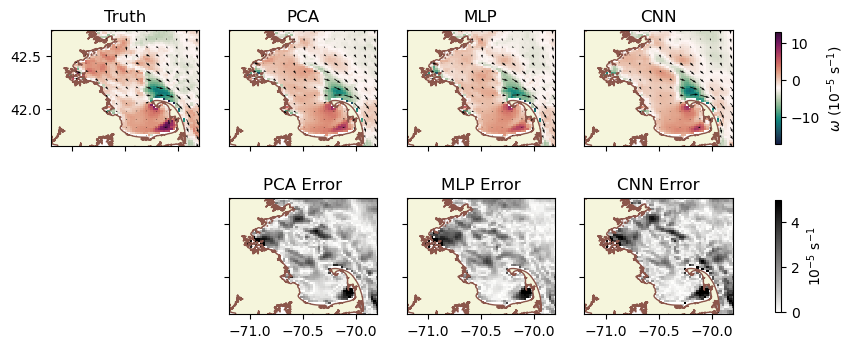

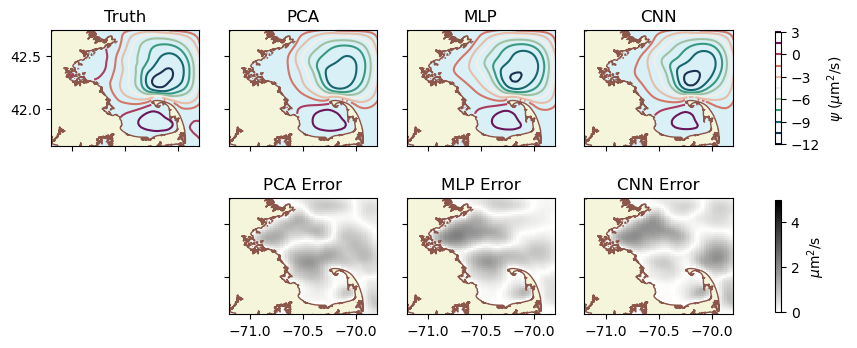

In [57]:
# Choose a timestep to visualize
timestep = 13833

def plot_contours(data_dict, title, grid_x, grid_y, row_idx=0, cmap=cm.cm.curl):
    arrs = [np.array(arr[timestep]) for arr in data_dict.values()]
    if title == '$\omega$':
        vmin = 100000 * min(np.nanmin(arr) for arr in arrs)
        vmax = 100000 * max(np.nanmax(arr) for arr in arrs)
    elif title == '$\psi$':
        vmin = min(np.nanmin(arr) for arr in arrs) / 1000
        vmax = max(np.nanmax(arr) for arr in arrs) / 1000
    for i, (key, arr) in enumerate(data_dict.items()):
        ax = axs[row_idx, i]
        if title == '$\omega$':
            cf = ax.pcolormesh(grid_x, grid_y, 100000 * np.array(arr[timestep]), vmin=vmin, vmax=vmax, cmap=cmap)
        elif title == '$\psi$':
            ax.set_facecolor(np.array([218, 240, 247]) / 255)
            cf = ax.contour(grid_x, grid_y, np.array(arr[timestep]) / 1000, levels=10, vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(key)
        mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_aspect('equal')
    # Shared colorbar for the row
    fig.colorbar(cf, ax=axs[row_idx, :], orientation='vertical', shrink=0.8,
                 label=('$\psi$ ($\mu$m$^2$/s)' if title == '$\psi$' else '$\omega$ (10$^{-5}$ s$^{-1}$)'))

def plot_error_contours(true_dict, pred_dict, title, grid_x, grid_y, row_idx=0, cmap=cm.cm.gray_r):
    true_arr = np.array(true_dict['Truth'][timestep])
    vmin = 0
    if title == '$\omega$ error':
        vmax = 5
    elif title == '$\psi$ error':
        vmax = 5
    for i, key in enumerate(pred_dict.keys()):
        ax = axs[row_idx, i+1]
        pred_arr = np.array(pred_dict[key][timestep])
        err = np.abs(pred_arr - true_arr)
        if title == '$\omega$ error':
            cf = ax.pcolormesh(grid_x, grid_y, 100000 * err, cmap=cmap, vmin=vmin, vmax=vmax)
        elif title == '$\psi$ error':
            cf = ax.pcolormesh(grid_x, grid_y, err / 1000, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(key + ' Error')
        mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_aspect('equal')
    # Shared colorbar for the error row (skip axs[1,0])
    fig.colorbar(cf, ax=axs[row_idx, :], orientation='vertical', shrink=0.8,
                 label=('$\mu$m$^2$/s' if title == '$\psi$ error' else '10$^{-5}$ s$^{-1}$'))

fig, axs = plt.subplots(2, 4, figsize=(11, 4), sharex=True, sharey=True)
plot_contours(omega_fields, '$\omega$', grid_x, grid_y, row_idx=0)
step = 4
xq, yq, mask_q = grid_x[::step, ::step], grid_y[::step, ::step], mask[::step, ::step]
for i, (key, (u, v)) in enumerate(fields.items()):
    ax = axs[0, i]
    ax.quiver(xq[mask_q], yq[mask_q], u[timestep, ::step, ::step][mask_q], v[timestep, ::step, ::step][mask_q], scale=7, scale_units='xy')
    ax.set_title(key)
axs[1, 0].axis('off')
plot_error_contours(omega_fields, {k: omega_fields[k] for k in ['PCA', 'MLP', 'CNN']}, '$\omega$ error', grid_x, grid_y, row_idx=1)
plt.savefig(f'{project_root}/figures/{project}/bo/vorticity_comparison_latent_dim_{latent_dim}_idx_{timestep}.png', dpi=300, bbox_inches='tight')

fig, axs = plt.subplots(2, 4, figsize=(11, 4), sharex=True, sharey=True)
plot_contours(psi_fields, '$\psi$', grid_x, grid_y, row_idx=0)
axs[1, 0].axis('off')
plot_error_contours(psi_fields, {k: psi_fields[k] for k in ['PCA', 'MLP', 'CNN']}, '$\psi$ error', grid_x, grid_y, row_idx=1)
plt.savefig(f'{project_root}/figures/{project}/bo/streamfunction_comparison_latent_dim_{latent_dim}_idx_{timestep}.png', dpi=300, bbox_inches='tight')